# Introduction

<p>This is my first attempt at an exploratory data analysis, where I will be looking at powerlifting data gathered and provided by the OpenPowerlifting project. (You may download a copy of the data [here](https://gitlab.com/openpowerlifting/opl-data))</p>

<p>I've lifted as a hobby for a number of years now, and figured that a great introduction to data analysis would be with something I'm already passionate about. In the analysis I hope to generate some novel understanding of general powerlifting trends in regards to competitions and how I might compare to those at the highest level.</p>

## Step 1: Importing Data and Relevant Packages

In [1]:
# Importing useful packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from scipy import stats

In [2]:
# Importing the dataset 
path = r'C:\Users\kikip\Powerlifting Project\Input\openpowerlifting-2025-02-01.csv'
raw = pd.read_csv(path, parse_dates=['Date'], low_memory=False)

In [3]:
# Intial raw data scan
raw.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3487219 entries, 0 to 3487218
Data columns (total 42 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   Name              3487219 non-null  object        
 1   Sex               3487219 non-null  object        
 2   Event             3487219 non-null  object        
 3   Equipment         3487219 non-null  object        
 4   Age               2203438 non-null  float64       
 5   AgeClass          2513695 non-null  object        
 6   BirthYearClass    2279716 non-null  object        
 7   Division          3483691 non-null  object        
 8   BodyweightKg      3445574 non-null  float64       
 9   WeightClassKg     3437546 non-null  object        
 10  Squat1Kg          1067280 non-null  float64       
 11  Squat2Kg          1057004 non-null  float64       
 12  Squat3Kg          1030329 non-null  float64       
 13  Squat4Kg          9099 non-null     float6

## Step 2: Initial Data Pruning
<p>Wow! Over 1.1 GB of data, ranging from athlete characteristics, to weight totals, to competition details. I will have to break down the over 3 million records into a smaller subset that is easier for me to handle.</p>
I will condense the data initially based on these characteristics:

1. Results from New Jersey,
2. Meets that are both Tested and Sanctioned,
3. A full powerlifting meet (comprising of squat, bench, and deadlift)

In [4]:
# The top 20 states by number of competitions
raw[raw.MeetCountry == 'USA'].MeetState.value_counts().head(20)

MeetState
TX    821642
CA    105750
PA     67694
FL     65763
OH     55373
NV     50757
NY     42631
IL     42106
VA     36885
NJ     32508
GA     30892
NC     30090
MI     29986
LA     24750
WI     24743
WA     22453
OK     20263
MO     20229
AZ     19678
CO     19573
Name: count, dtype: int64

In [5]:
# Create a subset based on the criteria listed above
nj = raw.loc[(raw.MeetState == 'NJ') & (raw.Tested == 'Yes') & (raw.Sanctioned == 'Yes') & (raw.Event == 'SBD')].reset_index(drop=True)

# An overview of the subset
nj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17123 entries, 0 to 17122
Data columns (total 42 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Name              17123 non-null  object        
 1   Sex               17123 non-null  object        
 2   Event             17123 non-null  object        
 3   Equipment         17123 non-null  object        
 4   Age               12192 non-null  float64       
 5   AgeClass          13906 non-null  object        
 6   BirthYearClass    12689 non-null  object        
 7   Division          17123 non-null  object        
 8   BodyweightKg      16854 non-null  float64       
 9   WeightClassKg     17023 non-null  object        
 10  Squat1Kg          8045 non-null   float64       
 11  Squat2Kg          7989 non-null   float64       
 12  Squat3Kg          7893 non-null   float64       
 13  Squat4Kg          34 non-null     float64       
 14  Best3SquatKg      1676

After going through the provided README, it seems like there are quite a few columns that are no longer needed because they are either redundant after the intial pruning (like **Tested**), uninteresting (like **Federation**), or simply have too many null values (like **Bench1Kg**)

In [6]:
# Dropping columns that will be unnecessary for EDA
nj = nj.drop(columns= ['Tested', 'MeetState', 'MeetCountry', 'Sanctioned', 'MeetName', 'MeetTown', 'ParentFederation', 'Federation', 'Squat1Kg', 'Squat2Kg',
                       'Squat3Kg', 'Squat4Kg', 'Bench1Kg', 'Bench2Kg', 'Bench3Kg', 'Bench4Kg', 'Deadlift1Kg', 'Deadlift2Kg', 'Deadlift3Kg', 'Deadlift4Kg',
                       'State', 'Country','Event', 'BirthYearClass'])

# Quick look to see if that worked
nj.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17123 entries, 0 to 17122
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Name             17123 non-null  object        
 1   Sex              17123 non-null  object        
 2   Equipment        17123 non-null  object        
 3   Age              12192 non-null  float64       
 4   AgeClass         13906 non-null  object        
 5   Division         17123 non-null  object        
 6   BodyweightKg     16854 non-null  float64       
 7   WeightClassKg    17023 non-null  object        
 8   Best3SquatKg     16763 non-null  float64       
 9   Best3BenchKg     16682 non-null  float64       
 10  Best3DeadliftKg  16670 non-null  float64       
 11  TotalKg          16455 non-null  float64       
 12  Place            17123 non-null  object        
 13  Dots             16209 non-null  float64       
 14  Wilks            16209 non-null  float

In [7]:
# Checking the first 20 records
nj.head(20)

,Name,Sex,Equipment,Age,AgeClass,Division,BodyweightKg,WeightClassKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg,Place,Dots,Wilks,Glossbrenner,Goodlift,Date
0,AJ Dymond,M,Raw,16.0,16-17,TJ16-17,87.60,90,200.0,120.0,205.0,525.0,1,344.21,339.92,326.18,70.74,2024-03-16
1,Kathryn Laird,F,Raw,16.0,16-17,Teen 16-17,59.74,60,67.5,35.0,87.5,190.0,1,211.20,212.54,187.80,43.08,2022-01-16
2,Alysia Peters,F,Raw,17.0,16-17,Teen 16-17,60.69,67.5,65.0,30.0,87.5,182.5,1,200.86,201.68,178.17,40.93,2022-01-16
3,Naomi Kutin,F,Raw,20.0,20-23,Open,64.14,67.5,155.5,60.0,182.5,398.0,1,423.44,421.70,372.29,86.09,2022-01-16
4,Naomi Kutin,F,Raw,20.0,20-23,Juniors 20-24,64.14,67.5,155.5,60.0,182.5,398.0,1,423.44,421.70,372.29,86.09,2022-01-16
5,Isabella Smith,F,Raw,16.0,16-17,Teen 16-17,69.81,75,62.5,37.5,107.5,207.5,1,210.16,206.82,182.32,42.71,2022-01-16
6,Michael Neziri,M,Raw,11.0,5-12,Youth,29.39,48,35.0,20.0,52.5,107.5,1,136.64,143.56,142.37,NaN,2022-01-16
7,Alijah Rubang,M,Raw,16.0,16-17,Teen 16-17,59.97,60,77.5,47.5,120.0,245.0,1,206.88,209.05,204.14,40.19,2022-01-16
8,Joshua Persaud,M,Raw,16.0,16-17,Teen 16-17,60.46,67.5,97.5,75.0,155.0,327.5,1,274.70,277.38,270.75,53.49,2022-01-16
9,Darrell Terio,M,Raw,14.0,13-15,Teen 14-15,71.76,75,57.5,45.0,102.5,205.0,1,151.40,150.78,145.97,30.58,2022-01-16


After taking a look at the datatypes, null counts and README file, I've selected a few columns to inspect for various reasons.

1. Place
2. Division
3. WeightClassKg

In [8]:
# Looking at values in Place column
nj.Place.value_counts()

Place
1     9400
2     2870
3     1394
4      821
DQ     645
5      536
6      354
7      249
8      172
G      128
9      127
10     102
11      72
12      55
13      41
14      30
15      23
NS      20
16      17
17      16
18      15
19       9
20       7
21       6
22       4
DD       3
23       2
24       2
25       2
26       1
Name: count, dtype: int64

It looks like the reason Place is of type object is because there are some special cases where the competitor wasn't awarded a place.

In [9]:
# Replacing all the non-numeric values with 0
nj.loc[nj.Place == 'DQ', 'Place'] = 0
nj.loc[nj.Place == 'DD', 'Place'] = 0
nj.loc[nj.Place == 'NS', 'Place'] = 0
nj.loc[nj.Place == 'G', 'Place'] = 0

In [10]:
# Checking to make sure removal worked correctly
nj.Place.value_counts().index

Index([ '1',  '2',  '3',  '4',    0,  '5',  '6',  '7',  '8',  '9', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26'],
      dtype='object', name='Place')

In [11]:
# Now that non-numeric values have been removed, I can convert the column type to an integer
nj.Place = nj.Place.astype(int)
nj.Place.dtype

dtype('int32')

In [12]:
# Looking at values in Division column
nj.Division.value_counts()

Division
MR-O            2374
Amateur Open    1815
Open            1313
FR-O            1178
MR-Jr           1145
                ... 
M 45-49            1
Law/Mil Sub        1
F-M1b              1
M-M4b              1
T18-19             1
Name: count, Length: 332, dtype: int64

There doesn't seem to be too much I can do to this column for now so I'll just leave it how it is

In [13]:
# Checking why WeightClassKg is non-numeric
nj.WeightClassKg.value_counts().head(30)

WeightClassKg
90      1975
75      1882
82.5    1870
100     1584
67.5    1413
110     1108
125      714
83       699
93       647
60       645
74       542
56       422
105      409
52       356
63       293
72       268
66       258
120      212
57       211
140      210
84       193
140+     115
84+      115
120+     112
48       108
125+     101
59        95
90+       59
69        46
100+      44
Name: count, dtype: int64

According to the README, the reason the WeightClassKg column is non-numeric is because of the weight class minimums, notated by a '+' to the right of the number

In [14]:
# Dropping all records in the weight class minimums
nj = nj.loc[~nj.WeightClassKg.str.contains(r'\+', na=True)].reset_index(drop=True)

# Checking to see if row drop was done correctly
nj.WeightClassKg.value_counts().index

Index(['90', '75', '82.5', '100', '67.5', '110', '125', '83', '93', '60', '74',
       '56', '105', '52', '63', '72', '66', '120', '57', '140', '84', '48',
       '59', '69', '44', '47', '145', '76', '113.4', '40', '53', '83.9', '127',
       '136', '92.9', '43', '70.3', '102', '77.1', '35', '36.2', '63.5',
       '45.3', '78.9', '50.5', '30', '34', '58.9', '72.5', '49.9', '70', '62',
       '48.5', '94.5', '80.5', '88', '97.5', '89', '155'],
      dtype='object', name='WeightClassKg')

In [15]:
# Converting WeightClassKg to a float now that all non-numeric values are gone
nj.WeightClassKg = nj.WeightClassKg.astype(float)

# Rechecking the type
nj.WeightClassKg.dtype

dtype('float64')

In [16]:
# Overview of the data now that those columns are gone/fixed
nj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16376 entries, 0 to 16375
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Name             16376 non-null  object        
 1   Sex              16376 non-null  object        
 2   Equipment        16376 non-null  object        
 3   Age              11669 non-null  float64       
 4   AgeClass         13325 non-null  object        
 5   Division         16376 non-null  object        
 6   BodyweightKg     16376 non-null  float64       
 7   WeightClassKg    16376 non-null  float64       
 8   Best3SquatKg     16047 non-null  float64       
 9   Best3BenchKg     15964 non-null  float64       
 10  Best3DeadliftKg  15961 non-null  float64       
 11  TotalKg          15753 non-null  float64       
 12  Place            16376 non-null  int32         
 13  Dots             15753 non-null  float64       
 14  Wilks            15753 non-null  float

In [17]:
# Quick numeric summary to see if there are any obvious anomalies in the remaining data
nj.describe()

,Age,BodyweightKg,WeightClassKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg,Place,Dots,Wilks,Glossbrenner,Goodlift,Date
count,11669.000000,16376.000000,16376.000000,16047.000000,15964.000000,15961.000000,15753.000000,16376.000000,15753.000000,15753.000000,15753.000000,15742.000000,16376
mean,28.468849,82.799361,84.752943,168.692134,110.977108,195.541982,475.240564,2.153334,344.003451,341.919257,322.720868,68.307520,2016-01-01 18:36:03.165608192
min,7.500000,28.500000,30.000000,20.410000,15.880000,-249.480000,66.900000,0.000000,49.970000,49.380000,47.440000,8.770000,1983-11-20 00:00:00
25%,20.500000,68.242500,72.000000,124.740000,75.000000,151.950000,356.070000,1.000000,304.320000,302.290000,281.340000,60.162500,2014-08-02 00:00:00
50%,24.500000,81.500000,82.500000,172.370000,115.000000,202.500000,492.150000,1.000000,347.900000,346.010000,326.730000,69.200000,2018-03-18 00:00:00
75%,33.500000,94.400000,100.000000,208.650000,140.610000,235.870000,585.000000,2.000000,388.080000,385.220000,367.140000,77.310000,2022-05-14 00:00:00
max,87.000000,145.000000,155.000000,412.500000,317.510000,394.630000,987.500000,25.000000,566.050000,562.720000,538.510000,107.720000,2025-01-19 00:00:00
std,12.053492,18.954094,19.402023,56.364590,41.116709,54.896240,145.738039,2.353026,64.119534,63.478684,63.430201,13.082731,NaN


<p>Looking at the README it seems that failed lifts were denoted with negatives, explaining the negative minimum Best3DeadliftKg.</p>

<p>I will drop all the rows with negative numbers for the three lifts, which should also remove null values in the TotalKg category, as failing to record an approved lift in one of the events disqualifies you from the whole competition</p>

In [18]:
# Dropping all rows with negative numbers
nj = nj.loc[(nj.Best3SquatKg > 0) & (nj.Best3BenchKg > 0) & (nj.Best3DeadliftKg > 0)].reset_index(drop=True)

# Reinspecting the data to see if drop was successful
nj.describe()

,Age,BodyweightKg,WeightClassKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg,Place,Dots,Wilks,Glossbrenner,Goodlift,Date
count,11258.000000,15763.000000,15763.000000,15763.000000,15763.000000,15763.000000,15749.000000,15763.000000,15749.000000,15749.000000,15749.000000,15738.000000,15763
mean,28.446927,82.696496,84.663192,168.602627,111.011958,195.694637,475.251679,2.236630,344.023370,341.939405,322.739133,68.313413,2016-01-17 10:37:22.263528448
min,7.500000,28.500000,30.000000,20.410000,15.880000,20.410000,66.900000,0.000000,49.970000,49.380000,47.440000,8.770000,1983-11-20 00:00:00
25%,20.500000,68.000000,72.000000,124.740000,75.000000,152.455000,356.070000,1.000000,304.320000,302.380000,281.350000,60.172500,2014-08-02 00:00:00
50%,24.500000,81.500000,82.500000,172.370000,115.000000,202.500000,492.150000,1.000000,347.900000,346.020000,326.730000,69.200000,2018-05-19 00:00:00
75%,33.500000,93.925000,100.000000,207.500000,140.610000,235.870000,585.000000,2.000000,388.090000,385.220000,367.180000,77.317500,2022-05-31 12:00:00
max,87.000000,145.000000,155.000000,412.500000,317.510000,394.630000,987.500000,25.000000,566.050000,562.720000,538.510000,107.720000,2025-01-19 00:00:00
std,12.034590,18.900594,19.365702,56.262124,41.111157,54.753110,145.752958,2.359184,64.113839,63.472520,63.426409,13.078935,NaN


In [19]:
# Checking the number of null values in TotalKg
nj.TotalKg.isnull().sum()

14

It seems that there were a few more entries who were disqualified and don't have a total, so I will just manually remove any rows with missing TotalKg values

In [20]:
# Removing rows with missing totals
nj = nj.loc[~nj.TotalKg.isnull()].reset_index(drop=True)

# Checking to see if there are any remaining null values in TotalKg
nj.TotalKg.isnull().sum()

0

In [21]:
# One last reinspection
nj.describe()

,Age,BodyweightKg,WeightClassKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg,Place,Dots,Wilks,Glossbrenner,Goodlift,Date
count,11247.000000,15749.000000,15749.000000,15749.000000,15749.000000,15749.000000,15749.000000,15749.000000,15749.000000,15749.000000,15749.000000,15738.000000,15749
mean,28.443274,82.696014,84.662512,168.601425,110.991051,195.659519,475.251679,2.238618,344.023370,341.939405,322.739133,68.313413,2016-01-16 12:06:37.739538944
min,7.500000,28.500000,30.000000,20.410000,15.880000,20.410000,66.900000,0.000000,49.970000,49.380000,47.440000,8.770000,1983-11-20 00:00:00
25%,20.500000,68.000000,72.000000,124.740000,75.000000,152.410000,356.070000,1.000000,304.320000,302.380000,281.350000,60.172500,2014-08-02 00:00:00
50%,24.500000,81.500000,82.500000,172.370000,115.000000,202.500000,492.150000,1.000000,347.900000,346.020000,326.730000,69.200000,2018-05-19 00:00:00
75%,33.500000,93.900000,100.000000,207.500000,140.610000,235.870000,585.000000,2.000000,388.090000,385.220000,367.180000,77.317500,2022-06-18 00:00:00
max,87.000000,145.000000,155.000000,412.500000,317.510000,370.000000,987.500000,25.000000,566.050000,562.720000,538.510000,107.720000,2025-01-19 00:00:00
std,12.034780,18.901419,19.366409,56.268024,41.099409,54.724222,145.752958,2.359290,64.113839,63.472520,63.426409,13.078935,NaN


The final thing I will check for is if there are any duplicate records

In [22]:
nj.loc[nj.duplicated(keep=False)]

,Name,Sex,Equipment,Age,AgeClass,Division,BodyweightKg,WeightClassKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg,Place,Dots,Wilks,Glossbrenner,Goodlift,Date
4033,Kaisheem Muhammad,M,Raw,40.5,40-44,MR-G,96.60,105.0,232.50,140.00,247.5,620.0,0,387.53,382.81,365.91,79.63,2017-06-03
4034,Kaisheem Muhammad,M,Raw,40.5,40-44,MR-G,96.60,105.0,232.50,140.00,247.5,620.0,0,387.53,382.81,365.91,79.63,2017-06-03
4432,Diana Lwanga,F,Raw,33.5,24-34,FR-O,79.90,84.0,145.00,82.50,185.0,412.5,1,388.92,377.70,331.26,79.52,2016-08-05
4606,Diana Lwanga,F,Raw,33.5,24-34,FR-O,79.90,84.0,145.00,82.50,185.0,412.5,1,388.92,377.70,331.26,79.52,2016-08-05
11047,Michael Franco,M,Raw,35.5,35-39,Amateur Submasters 33-39,109.86,110.0,219.99,127.01,240.4,587.4,1,348.06,345.82,330.50,71.03,2016-11-12
11049,Michael Franco,M,Raw,35.5,35-39,Amateur Submasters 33-39,109.86,110.0,219.99,127.01,240.4,587.4,1,348.06,345.82,330.50,71.03,2016-11-12


It seems that there are only 3 duplicate records, so I will just remove one of the duplicates for each record

In [23]:
# Dropping duplicates
nj = nj.loc[~nj.duplicated()].reset_index(drop=True)

# Check for any more duplicates
nj.duplicated(keep=False).sum()

0

In [24]:
# Rechecking the data
nj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Name             15746 non-null  object        
 1   Sex              15746 non-null  object        
 2   Equipment        15746 non-null  object        
 3   Age              11244 non-null  float64       
 4   AgeClass         12830 non-null  object        
 5   Division         15746 non-null  object        
 6   BodyweightKg     15746 non-null  float64       
 7   WeightClassKg    15746 non-null  float64       
 8   Best3SquatKg     15746 non-null  float64       
 9   Best3BenchKg     15746 non-null  float64       
 10  Best3DeadliftKg  15746 non-null  float64       
 11  TotalKg          15746 non-null  float64       
 12  Place            15746 non-null  int32         
 13  Dots             15746 non-null  float64       
 14  Wilks            15746 non-null  float

In [25]:
# Looking at the first 20 records
nj.head(20)

,Name,Sex,Equipment,Age,AgeClass,Division,BodyweightKg,WeightClassKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg,Place,Dots,Wilks,Glossbrenner,Goodlift,Date
0,AJ Dymond,M,Raw,16.0,16-17,TJ16-17,87.60,90.0,200.0,120.0,205.0,525.0,1,344.21,339.92,326.18,70.74,2024-03-16
1,Kathryn Laird,F,Raw,16.0,16-17,Teen 16-17,59.74,60.0,67.5,35.0,87.5,190.0,1,211.20,212.54,187.80,43.08,2022-01-16
2,Alysia Peters,F,Raw,17.0,16-17,Teen 16-17,60.69,67.5,65.0,30.0,87.5,182.5,1,200.86,201.68,178.17,40.93,2022-01-16
3,Naomi Kutin,F,Raw,20.0,20-23,Open,64.14,67.5,155.5,60.0,182.5,398.0,1,423.44,421.70,372.29,86.09,2022-01-16
4,Naomi Kutin,F,Raw,20.0,20-23,Juniors 20-24,64.14,67.5,155.5,60.0,182.5,398.0,1,423.44,421.70,372.29,86.09,2022-01-16
5,Isabella Smith,F,Raw,16.0,16-17,Teen 16-17,69.81,75.0,62.5,37.5,107.5,207.5,1,210.16,206.82,182.32,42.71,2022-01-16
6,Michael Neziri,M,Raw,11.0,5-12,Youth,29.39,48.0,35.0,20.0,52.5,107.5,1,136.64,143.56,142.37,NaN,2022-01-16
7,Alijah Rubang,M,Raw,16.0,16-17,Teen 16-17,59.97,60.0,77.5,47.5,120.0,245.0,1,206.88,209.05,204.14,40.19,2022-01-16
8,Joshua Persaud,M,Raw,16.0,16-17,Teen 16-17,60.46,67.5,97.5,75.0,155.0,327.5,1,274.70,277.38,270.75,53.49,2022-01-16
9,Darrell Terio,M,Raw,14.0,13-15,Teen 14-15,71.76,75.0,57.5,45.0,102.5,205.0,1,151.40,150.78,145.97,30.58,2022-01-16


It looks like that it was possible to compete in multiple divisions at the same meet, so now there are some more duplicates I have to remove.

In [26]:
# One example of competing in multiple divisions
nj.iloc[[3,4]]

,Name,Sex,Equipment,Age,AgeClass,Division,BodyweightKg,WeightClassKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg,Place,Dots,Wilks,Glossbrenner,Goodlift,Date
3,Naomi Kutin,F,Raw,20.0,20-23,Open,64.14,67.5,155.5,60.0,182.5,398.0,1,423.44,421.7,372.29,86.09,2022-01-16
4,Naomi Kutin,F,Raw,20.0,20-23,Juniors 20-24,64.14,67.5,155.5,60.0,182.5,398.0,1,423.44,421.7,372.29,86.09,2022-01-16


In [27]:
# Making sure I have good criteria to determine more duplicates
nj[nj[['Name','Sex','BodyweightKg','TotalKg','Age']].duplicated(keep = False)]

,Name,Sex,Equipment,Age,AgeClass,Division,BodyweightKg,WeightClassKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg,Place,Dots,Wilks,Glossbrenner,Goodlift,Date
3,Naomi Kutin,F,Raw,20.0,20-23,Open,64.14,67.5,155.5,60.0,182.5,398.0,1,423.44,421.70,372.29,86.09,2022-01-16
4,Naomi Kutin,F,Raw,20.0,20-23,Juniors 20-24,64.14,67.5,155.5,60.0,182.5,398.0,1,423.44,421.70,372.29,86.09,2022-01-16
14,Ari Kutin,M,Raw,18.0,18-19,Open,93.17,100.0,215.0,115.0,262.5,592.5,1,376.65,371.88,355.90,77.44,2022-01-16
15,Ari Kutin,M,Raw,18.0,18-19,Teen 18-19,93.17,100.0,215.0,115.0,262.5,592.5,1,376.65,371.88,355.90,77.44,2022-01-16
23,An Nguyen #2,M,Raw,22.0,20-23,Open,59.50,60.0,167.5,112.5,180.0,460.0,1,390.95,395.34,386.24,75.77,2022-06-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15738,Nick Squires,M,Raw,37.0,35-39,Open,99.80,100.0,277.5,170.0,290.0,737.5,2,454.34,449.19,429.05,93.26,2023-10-07
15740,Ryan J Stills,M,Raw,46.0,45-49,Open,118.00,125.0,320.0,195.0,340.0,855.0,1,493.82,493.53,472.80,100.12,2023-10-07
15741,Ryan J Stills,M,Raw,46.0,45-49,M45-49,118.00,125.0,320.0,195.0,340.0,855.0,1,493.82,493.53,472.80,100.12,2023-10-07
15742,Sarah Kashdan,F,Raw,38.0,35-39,Open,55.30,56.0,105.0,62.5,130.0,297.5,1,347.73,353.51,312.78,71.42,2023-10-07


In [28]:
# The categories used to determine duplicates will be Name, Sex, BodyweightKg, TotalKg, and Age
nj = nj.loc[~nj[['Name','Sex','BodyweightKg','TotalKg','Age']].duplicated()].reset_index(drop=True)

In [29]:
# Making sure there are no duplicates left
nj[nj[['Name','Sex','BodyweightKg','TotalKg','Age']].duplicated()]

,Name,Sex,Equipment,Age,AgeClass,Division,BodyweightKg,WeightClassKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg,Place,Dots,Wilks,Glossbrenner,Goodlift,Date


In [30]:
# A final overview of the data
nj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14140 entries, 0 to 14139
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Name             14140 non-null  object        
 1   Sex              14140 non-null  object        
 2   Equipment        14140 non-null  object        
 3   Age              9962 non-null   float64       
 4   AgeClass         11421 non-null  object        
 5   Division         14140 non-null  object        
 6   BodyweightKg     14140 non-null  float64       
 7   WeightClassKg    14140 non-null  float64       
 8   Best3SquatKg     14140 non-null  float64       
 9   Best3BenchKg     14140 non-null  float64       
 10  Best3DeadliftKg  14140 non-null  float64       
 11  TotalKg          14140 non-null  float64       
 12  Place            14140 non-null  int32         
 13  Dots             14140 non-null  float64       
 14  Wilks            14140 non-null  float

## Step 3: Imputation and Data Manipulation
<p>Now that I've made some prelimiary edits to the data set, there are a few things that I will do that I think will make further analysis a little bit easier for me.</p>

<p>The first thing I will do is create columns with pounds corresponding to the weight columns currently in kilograms, since they will be a little bit more intuitive for me, and then I will take a look at the remaining null values in the GoodLift column to see if I can do anything about those.</p>

In [31]:
# Initialize a list of columns containing weights in kilograms
kg_columns = []

for column in nj.columns:
    if 'Kg' in column:
        kg_columns.append(column)

# Create corresponding columns with the pound equivalents (rounded to one decimal place for consistency)
for column in kg_columns:
    nj[column.replace('Kg', 'Lb')] = round(nj[column] * 2.204, 1)

<p>Powerlifting competitions typically use a score calculation to determine the best overall lifters, regardless of bodyweight.
There are a few different types of calculations used; Wilks, Dots, Glossbrenner, and GoodLift.
The actual differences between the calculations are quite small, but it looks like some values are missing in the GoodLift column</p>

<p>It seems that I have all of the necessary data to manually calculate the missing Goodlift values, so I will have to find the official equation</p>

In [32]:
# Initializing GoodLift coefficients to calculate a competitor's missing GoodLift score
equipped_M = [1236.25115, 1449.21864, 0.01644]
raw_M = [1199.72839, 1025.18162, 0.00921]
equipped_F = [758.63878, 949.31382, 0.02435]
raw_F = [610.32796, 1045.59282, 0.03048]

In [33]:
# Checking lifters with missing GoodLift score
display(nj.loc[nj.Goodlift.isnull(), ['Name','Sex', 'Equipment', 'BodyweightKg', 'TotalKg', 'Goodlift']])

# Getting the indices of all the blanks to double check afterwards
GL_check = nj.loc[nj.Goodlift.isnull(), ['Name', 'Sex', 'Equipment', 'BodyweightKg', 'TotalKg', 'Goodlift']].index

,Name,Sex,Equipment,BodyweightKg,TotalKg,Goodlift
5,Michael Neziri,M,Raw,29.39,107.50,NaN
19,Michael Neziri Jr,M,Raw,32.40,117.50,NaN
86,Michael Neziri Jr,M,Raw,32.80,130.00,NaN
100,Michael Neziri Jr,M,Raw,32.25,137.50,NaN
520,Cash McVey,M,Raw,31.70,147.50,NaN
4878,Evangeline Checchio,F,Raw,28.50,77.50,NaN
4919,Maxim Smirnov,M,Raw,34.80,155.00,NaN
5343,Nathan Alexander #2,M,Raw,34.90,125.00,NaN
5669,Cash McVey,M,Raw,31.70,165.00,NaN
6116,Damiyah Smith,F,Raw,34.02,163.29,NaN


In [34]:
# Replacing all the missing Goodlift values with the correct values, based on attribute-specific coefficients
for i in range(len(nj)):
    if np.isnan(nj.iloc[i].Goodlift):
        if nj.iloc[i].Sex == 'F':
            if nj.iloc[i].Equipment == 'Single-ply':
                nj.at[i,'Goodlift'] = round(100/(equipped_F[0]-equipped_F[1]*np.exp(-equipped_F[2]*nj.iloc[i].BodyweightKg))*nj.iloc[i].TotalKg,2)
            # Raw and Wraps use the same coefficients.
            else:
                nj.at[i,'Goodlift'] = round(100/(raw_F[0]-raw_F[1]*np.exp(-raw_F[2]*nj.iloc[i].BodyweightKg))*nj.iloc[i].TotalKg,2)
        elif nj.iloc[i].Sex == 'M':
            if nj.iloc[i].Equipment == 'Single-ply':
                nj.at[i,'Goodlift'] = round(100/(equipped_M[0]-equipped_M[1]*np.exp(-equipped_M[2]*nj.iloc[i].BodyweightKg))*nj.iloc[i].TotalKg,2)
            # Raw and Wraps use the same coefficients.
            else:
                nj.at[i,'Goodlift'] = round(100/(raw_M[0]-raw_M[1]*np.exp(-raw_M[2]*nj.iloc[i].BodyweightKg))*nj.iloc[i].TotalKg,2)

In [35]:
# Double checking that the coefficients were correctly replaced
nj.iloc[GL_check][['Name', 'Sex', 'Equipment', 'BodyweightKg', 'TotalKg', 'Goodlift']]

,Name,Sex,Equipment,BodyweightKg,TotalKg,Goodlift
5,Michael Neziri,M,Raw,29.39,107.50,25.74
19,Michael Neziri Jr,M,Raw,32.40,117.50,26.76
86,Michael Neziri Jr,M,Raw,32.80,130.00,29.42
100,Michael Neziri Jr,M,Raw,32.25,137.50,31.39
520,Cash McVey,M,Raw,31.70,147.50,33.98
4878,Evangeline Checchio,F,Raw,28.50,77.50,45.14
4919,Maxim Smirnov,M,Raw,34.80,155.00,34.02
5343,Nathan Alexander #2,M,Raw,34.90,125.00,27.39
5669,Cash McVey,M,Raw,31.70,165.00,38.01
6116,Damiyah Smith,F,Raw,34.02,163.29,68.14


I just realized that since I want to analyze powerlifting trends over time, I will need a better record of how the sport has progressed. To do this, I'll make a new column with the year of the meet.

In [36]:
nj['MeetYear'] = nj.Date.dt.year

In [37]:
# Looking at the finalized data
nj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14140 entries, 0 to 14139
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Name             14140 non-null  object        
 1   Sex              14140 non-null  object        
 2   Equipment        14140 non-null  object        
 3   Age              9962 non-null   float64       
 4   AgeClass         11421 non-null  object        
 5   Division         14140 non-null  object        
 6   BodyweightKg     14140 non-null  float64       
 7   WeightClassKg    14140 non-null  float64       
 8   Best3SquatKg     14140 non-null  float64       
 9   Best3BenchKg     14140 non-null  float64       
 10  Best3DeadliftKg  14140 non-null  float64       
 11  TotalKg          14140 non-null  float64       
 12  Place            14140 non-null  int32         
 13  Dots             14140 non-null  float64       
 14  Wilks            14140 non-null  float

In [38]:
nj.head()

,Name,Sex,Equipment,Age,AgeClass,Division,BodyweightKg,WeightClassKg,Best3SquatKg,Best3BenchKg,...,Glossbrenner,Goodlift,Date,BodyweightLb,WeightClassLb,Best3SquatLb,Best3BenchLb,Best3DeadliftLb,TotalLb,MeetYear
0,AJ Dymond,M,Raw,16.0,16-17,TJ16-17,87.60,90.0,200.0,120.0,...,326.18,70.74,2024-03-16,193.1,198.4,440.8,264.5,451.8,1157.1,2024
1,Kathryn Laird,F,Raw,16.0,16-17,Teen 16-17,59.74,60.0,67.5,35.0,...,187.80,43.08,2022-01-16,131.7,132.2,148.8,77.1,192.9,418.8,2022
2,Alysia Peters,F,Raw,17.0,16-17,Teen 16-17,60.69,67.5,65.0,30.0,...,178.17,40.93,2022-01-16,133.8,148.8,143.3,66.1,192.9,402.2,2022
3,Naomi Kutin,F,Raw,20.0,20-23,Open,64.14,67.5,155.5,60.0,...,372.29,86.09,2022-01-16,141.4,148.8,342.7,132.2,402.2,877.2,2022
4,Isabella Smith,F,Raw,16.0,16-17,Teen 16-17,69.81,75.0,62.5,37.5,...,182.32,42.71,2022-01-16,153.9,165.3,137.8,82.6,236.9,457.3,2022


In [39]:
nj.describe()

,Age,BodyweightKg,WeightClassKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg,Place,Dots,Wilks,Glossbrenner,Goodlift,Date,BodyweightLb,WeightClassLb,Best3SquatLb,Best3BenchLb,Best3DeadliftLb,TotalLb,MeetYear
count,9962.000000,14140.000000,14140.000000,14140.000000,14140.000000,14140.000000,14140.000000,14140.000000,14140.000000,14140.000000,14140.000000,14140.000000,14140,14140.000000,14140.000000,14140.000000,14140.000000,14140.000000,14140.000000,14140.000000
mean,28.316453,82.726597,84.706011,167.924295,110.768443,195.050289,473.742694,2.224470,342.347946,340.265051,321.285815,67.935168,2015-12-27 17:29:45.233380608,182.328472,186.691973,370.105728,244.131747,429.892751,1044.129830,2015.466124
min,7.500000,28.500000,30.000000,20.410000,15.880000,20.410000,66.900000,0.000000,49.970000,49.380000,47.440000,8.770000,1983-11-20 00:00:00,62.800000,66.100000,45.000000,35.000000,45.000000,147.400000,1983.000000
25%,20.500000,68.600000,72.000000,124.740000,75.000000,151.950000,355.000000,1.000000,302.312500,300.490000,279.677500,59.780000,2014-08-02 00:00:00,151.200000,158.700000,274.900000,165.300000,334.900000,782.400000,2014.000000
50%,24.500000,81.500000,82.500000,170.100000,114.760000,201.850000,490.000000,1.000000,346.200000,343.955000,325.620000,68.870000,2018-02-11 00:00:00,179.600000,181.800000,374.900000,252.900000,444.900000,1080.000000,2018.000000
75%,32.500000,93.800000,100.000000,206.380000,140.610000,235.000000,580.600000,2.000000,386.475000,383.712500,365.912500,76.940000,2022-05-07 00:00:00,206.700000,220.400000,454.900000,309.900000,517.900000,1279.600000,2022.000000
max,87.000000,145.000000,155.000000,412.500000,317.510000,370.000000,987.500000,25.000000,566.050000,562.720000,538.510000,107.720000,2025-01-19 00:00:00,319.600000,341.600000,909.200000,699.800000,815.500000,2176.500000,2025.000000
std,11.984191,18.853025,19.313782,56.229760,41.149732,54.696503,145.741107,2.361932,64.390384,63.735005,63.628466,13.151686,NaN,41.545069,42.567484,123.933605,90.690265,120.552789,321.213557,8.713882


## Preliminary Investigation with Subset
<p>While I don't know too much about powerlifting history in New Jersey, in [2023](https://liftvault.com/strongest-states/) it was ranked in the top ten of US states when comparing each the average Dots score of each state's ten best lifters. It looks like Dots is becoming the most popular metric to compare lifters of different weights, so I'll primarily use that metric when comparing lifters.</p>

In [40]:
# Finding the best New Jersey lifters by dots
nj.Dots.value_counts().sort_index(ascending = False).head()

Dots
566.05    1
564.59    1
559.67    1
544.06    1
542.60    1
Name: count, dtype: int64

In [41]:
display(nj.loc[nj.Dots.isin(nj.Dots.value_counts().sort_index(ascending = False).head().index)].sort_values('Dots', ascending = False))

,Name,Sex,Equipment,Age,AgeClass,Division,BodyweightKg,WeightClassKg,Best3SquatKg,Best3BenchKg,...,Glossbrenner,Goodlift,Date,BodyweightLb,WeightClassLb,Best3SquatLb,Best3BenchLb,Best3DeadliftLb,TotalLb,MeetYear
9545,Dan Petrillo,M,Multi-ply,28.5,24-34,Amateur Open,90.0,90.0,340.19,254.01,...,535.62,96.60,2009-01-25,198.4,198.4,749.8,559.8,619.8,1929.4,2009
9546,David Kirschen,M,Multi-ply,NaN,NaN,Amateur Open,90.0,90.0,337.93,260.82,...,534.24,96.35,2009-01-25,198.4,198.4,744.8,574.8,604.8,1924.5,2009
6619,Jason Wood,M,Multi-ply,NaN,NaN,O,125.0,125.0,412.50,282.50,...,538.51,93.99,2009-10-17,275.5,275.5,909.2,622.6,644.7,2176.5,2009
13794,Ray Benemerito,M,Single-ply,34.5,24-34,M-O,90.0,90.0,301.64,219.99,...,514.81,92.85,2002-02-16,198.4,198.4,664.8,484.9,704.8,1854.5,2002
8476,Mike Mastrean,M,Single-ply,28.0,24-34,Open,90.0,90.0,333.39,215.46,...,513.42,92.60,1999-10-23,198.4,198.4,734.8,474.9,639.8,1849.5,1999


In [42]:
# Finding the heaviest totals by New Jersey lifters
nj.TotalKg.value_counts().sort_index(ascending = False).head()

TotalKg
987.50    1
898.11    1
889.04    2
886.77    1
885.00    1
Name: count, dtype: int64

In [43]:
display(nj.loc[nj.TotalKg.isin(nj.TotalKg.value_counts().sort_index(ascending = False).head().index)].sort_values('TotalKg', ascending = False))

,Name,Sex,Equipment,Age,AgeClass,Division,BodyweightKg,WeightClassKg,Best3SquatKg,Best3BenchKg,...,Glossbrenner,Goodlift,Date,BodyweightLb,WeightClassLb,Best3SquatLb,Best3BenchLb,Best3DeadliftLb,TotalLb,MeetYear
6619,Jason Wood,M,Multi-ply,NaN,NaN,O,125.00,125.0,412.50,282.50,...,538.51,93.99,2009-10-17,275.5,275.5,909.2,622.6,644.7,2176.5,2009
7191,Norman Rial,M,Multi-ply,34.5,24-34,M_OEM_AAPF,125.00,125.0,326.59,251.74,...,489.76,85.48,2007-01-13,275.5,275.5,719.8,554.8,704.8,1979.4,2007
10485,Darren Crumm,M,Multi-ply,NaN,40-44,Amateur Open,137.53,140.0,351.53,274.42,...,474.10,81.93,2012-09-07,303.1,308.6,774.8,604.8,579.8,1959.4,2012
12903,Joseph Rybaruk Jr,M,Multi-ply,NaN,40-44,Amateur Masters 40-44,119.75,125.0,331.12,317.51,...,490.02,85.99,2018-01-27,263.9,275.5,729.8,699.8,529.8,1959.4,2018
8516,Greg Payne,M,Raw,34.0,24-34,R Open,145.00,145.0,322.05,222.26,...,467.31,95.34,1999-10-23,319.6,319.6,709.8,489.9,754.8,1954.4,1999
1724,Chris Hughes #2,M,Single-ply,22.0,20-23,M-Jr,115.60,120.0,365.00,217.50,...,491.64,86.80,2015-08-01,254.8,264.5,804.5,479.4,666.7,1950.5,2015


Wow! Two fourty year olds with totals of 1959.4 lbs. That's seriously impressive, and I hope I can be that strong anytime in my life, much less at fourty years old.

<p>After a little digging, I found some more information about Joseph Rybaruk, and I can seriously say that this guy was an absolute unit.</p>

<p>His main lift is definitely the bench press, where he's achieved the lofty weight of over 1000 pounds multiple times in competition! That doesn't mean he was bad at the other lifts though, with life-time personal records of an 800 pound squat and 550 pound deadlift. Not only that, but he still trains regularly at the age of 47 with weights I can only imagine lifting. </p>

In [44]:
nj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14140 entries, 0 to 14139
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Name             14140 non-null  object        
 1   Sex              14140 non-null  object        
 2   Equipment        14140 non-null  object        
 3   Age              9962 non-null   float64       
 4   AgeClass         11421 non-null  object        
 5   Division         14140 non-null  object        
 6   BodyweightKg     14140 non-null  float64       
 7   WeightClassKg    14140 non-null  float64       
 8   Best3SquatKg     14140 non-null  float64       
 9   Best3BenchKg     14140 non-null  float64       
 10  Best3DeadliftKg  14140 non-null  float64       
 11  TotalKg          14140 non-null  float64       
 12  Place            14140 non-null  int32         
 13  Dots             14140 non-null  float64       
 14  Wilks            14140 non-null  float

In [45]:
nj.describe()

,Age,BodyweightKg,WeightClassKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg,Place,Dots,Wilks,Glossbrenner,Goodlift,Date,BodyweightLb,WeightClassLb,Best3SquatLb,Best3BenchLb,Best3DeadliftLb,TotalLb,MeetYear
count,9962.000000,14140.000000,14140.000000,14140.000000,14140.000000,14140.000000,14140.000000,14140.000000,14140.000000,14140.000000,14140.000000,14140.000000,14140,14140.000000,14140.000000,14140.000000,14140.000000,14140.000000,14140.000000,14140.000000
mean,28.316453,82.726597,84.706011,167.924295,110.768443,195.050289,473.742694,2.224470,342.347946,340.265051,321.285815,67.935168,2015-12-27 17:29:45.233380608,182.328472,186.691973,370.105728,244.131747,429.892751,1044.129830,2015.466124
min,7.500000,28.500000,30.000000,20.410000,15.880000,20.410000,66.900000,0.000000,49.970000,49.380000,47.440000,8.770000,1983-11-20 00:00:00,62.800000,66.100000,45.000000,35.000000,45.000000,147.400000,1983.000000
25%,20.500000,68.600000,72.000000,124.740000,75.000000,151.950000,355.000000,1.000000,302.312500,300.490000,279.677500,59.780000,2014-08-02 00:00:00,151.200000,158.700000,274.900000,165.300000,334.900000,782.400000,2014.000000
50%,24.500000,81.500000,82.500000,170.100000,114.760000,201.850000,490.000000,1.000000,346.200000,343.955000,325.620000,68.870000,2018-02-11 00:00:00,179.600000,181.800000,374.900000,252.900000,444.900000,1080.000000,2018.000000
75%,32.500000,93.800000,100.000000,206.380000,140.610000,235.000000,580.600000,2.000000,386.475000,383.712500,365.912500,76.940000,2022-05-07 00:00:00,206.700000,220.400000,454.900000,309.900000,517.900000,1279.600000,2022.000000
max,87.000000,145.000000,155.000000,412.500000,317.510000,370.000000,987.500000,25.000000,566.050000,562.720000,538.510000,107.720000,2025-01-19 00:00:00,319.600000,341.600000,909.200000,699.800000,815.500000,2176.500000,2025.000000
std,11.984191,18.853025,19.313782,56.229760,41.149732,54.696503,145.741107,2.361932,64.390384,63.735005,63.628466,13.151686,NaN,41.545069,42.567484,123.933605,90.690265,120.552789,321.213557,8.713882


# Step 4: Exploratory Data Analysis
<p>Now that all of the data has been cleaned up, it's time to start looking at some trends over the years.</p>

<p>I'll take a look at the following for males and females separately: </p>

- Relationship between bodyweight and total lifted,
- Correlation between bodyweight and each lift type,
- Relationship between age and total,
- How overall performances have changed over the years (weight and dots).

## The relationship between bodyweight and total lifted

In [46]:
# Helper function to title, label the axes, and despine the graphs
def label_and_despine(title = '', xlabel = '', ylabel = '', despine = True, subplots = False):
    if despine:
        sb.despine()
    
    if subplots:
        fig.suptitle(title)
    else:
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)

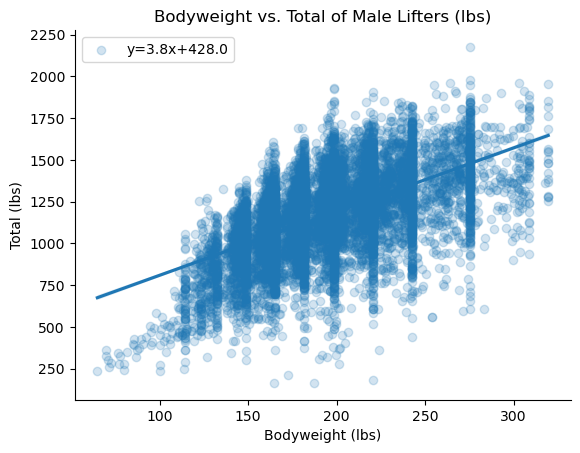

In [47]:
# Plotting bodyweight vs total of male lifters
slope_m, intercept_m, r_value_m, p_value_m, se_m = stats.linregress(nj.loc[nj.Sex=='M', 'BodyweightLb'], nj.loc[nj.Sex=='M', 'TotalLb'])

sb.regplot(y='TotalLb', x='BodyweightLb', data=nj[nj.Sex == 'M'], scatter_kws={'alpha':0.2}, label='y={0:.1f}x+{1:.1f}'.format(slope_m, intercept_m)).legend(loc='upper left')
label_and_despine('Bodyweight vs. Total of Male Lifters (lbs)', 'Bodyweight (lbs)', 'Total (lbs)')

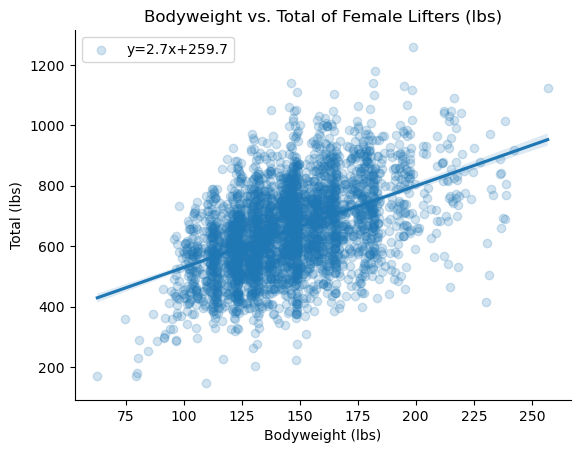

In [48]:
# Plotting bodyweight vs total of male lifters
slope_f, intercept_f, r_value_f, p_value_f, se_f = stats.linregress(nj.loc[nj.Sex=='F', 'BodyweightLb'], nj.loc[nj.Sex=='F', 'TotalLb'])

sb.regplot(y='TotalLb', x='BodyweightLb', data=nj[nj.Sex == 'F'], x_jitter=.5, scatter_kws={'alpha':.2}, label='y={0:.1f}x+{1:.1f}'.format(slope_f, intercept_f)).legend(loc='upper left')
label_and_despine('Bodyweight vs. Total of Female Lifters (lbs)', 'Bodyweight (lbs)', 'Total (lbs)')

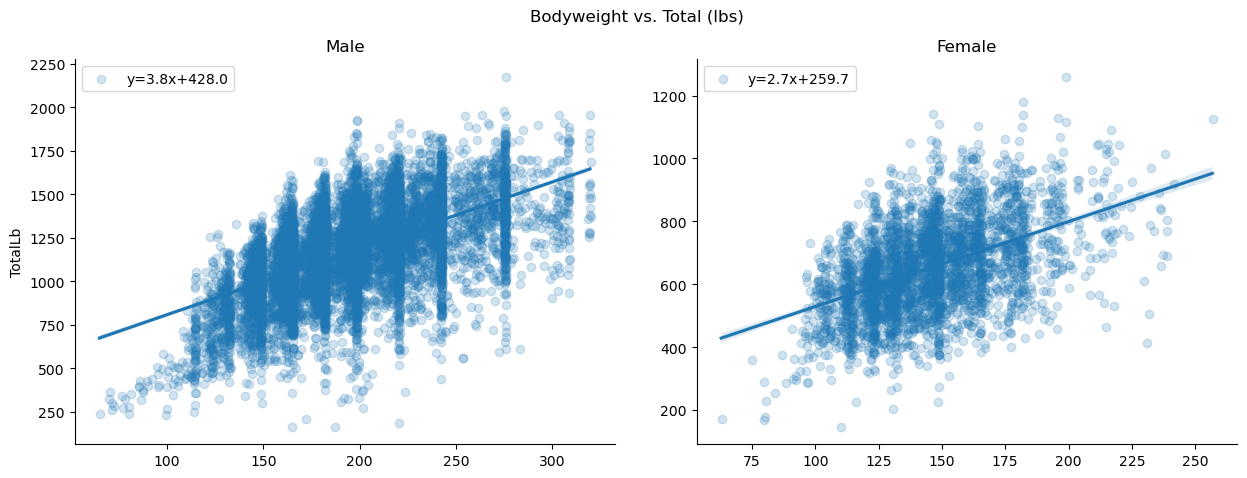

In [49]:
# Plotting bodyweight vs total of male and female lifters side by side
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting correlation matrices for males and females side by side
fig.suptitle('Bodyweight vs. Total (lbs)')
plt.subplots_adjust(wspace=.15)

sb.regplot(y='TotalLb', x='BodyweightLb', data=nj[nj.Sex == 'M'], x_jitter=.5, scatter_kws={'alpha':.2}, label='y={0:.1f}x+{1:.1f}'.format(slope_m, intercept_m), ax=ax[0]).set(title='Male')
ax[0].legend(loc='upper left')
ax[0].xaxis.label.set_visible(False)
sb.despine()

sb.regplot(y='TotalLb', x='BodyweightLb', data=nj[nj.Sex == 'F'], x_jitter=.5, scatter_kws={'alpha':.2}, label='y={0:.1f}x+{1:.1f}'.format(slope_f, intercept_f), ax=ax[1]).set(title='Female')
ax[1].legend(loc='upper left')
ax[1].xaxis.label.set_visible(False)
ax[1].yaxis.label.set_visible(False)
sb.despine()

Overall I'm not super surprised by these results, with the y-intercept for men almost 200 lbs more, but only about a one pound difference in the slope. With everything else equal, men gain about 1.1 times as much strength from every additional pound of bodyweight compared to women. Males and females gain about 3.8 lbs and 2.7 lbs for every additional pound of bodyweight across the three lifts, respectively.

## Correlation between bodyweight and each lift type

[Text(0.5, 1.0, 'Female')]

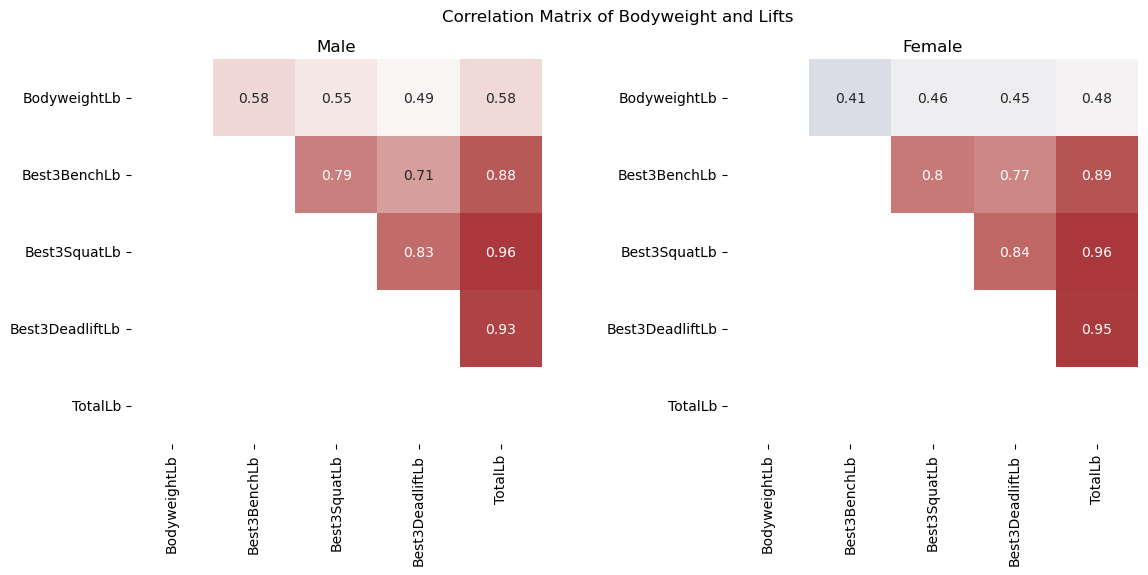

In [50]:
# Creating a mask to only show the top right of the correlation matrix
mask = np.tril(nj[['BodyweightLb', 'Best3BenchLb', 'Best3SquatLb', 'Best3DeadliftLb', 'TotalLb']].corr())

fig, ax = plt.subplots(1, 2, figsize = (13,5))

plt.subplots_adjust(wspace=0.45)
fig.suptitle('Correlation Matrix of Bodyweight and Lifts')

sb.heatmap(nj.loc[nj['Sex'] == 'M', ['BodyweightLb', 'Best3BenchLb', 'Best3SquatLb', 'Best3DeadliftLb', 'TotalLb']].corr(), annot=True, cmap='vlag', mask=mask, center=.5, cbar=False, ax=ax[0]).set(title='Male')
sb.heatmap(nj.loc[nj['Sex'] == 'F', ['BodyweightLb', 'Best3BenchLb', 'Best3SquatLb', 'Best3DeadliftLb', 'TotalLb']].corr(), annot=True, cmap='vlag', mask=mask, center=.5, cbar=False, ax=ax[1]).set(title='Female')

I'm quite surprised by how little bodyweight is correlated to overall total, but it does make sense that each of the lifts has a strong correlation to the total, as better lifters are usually not just better at one specific lift, they are better lifters overall. For male lifters, bodyweight is correlated the most with bench press, while for females it is correlated more with squats.

## Relationship between age and total

In [51]:
nj.Age.isnull().sum()

4178

One of the problems with analyzing age is that unfortunately a decent chunk of competitors simply don't have an age listed, so I will have to ignore these records when calculating any relationships. This does unfortunately cut off a little over 4000 records, but I don't really have a choice since there is no way to accurately determine those ages.

In [52]:
# Creating a new dataframe only containing records with non-null ages
nj_with_age = nj.loc[~nj.Age.isnull()].reset_index(drop=True)

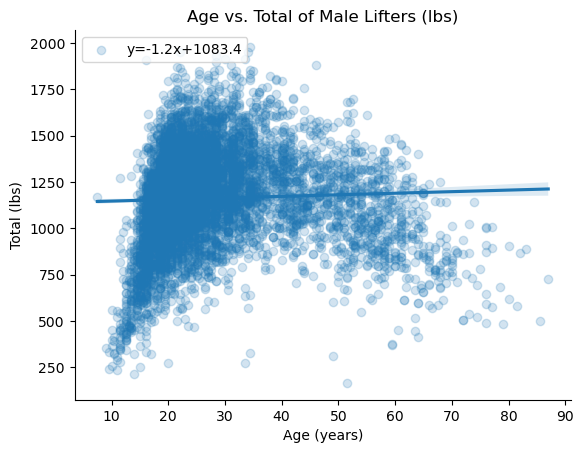

In [53]:
# Plotting bodyweight vs total of male lifters
slope_m, intercept_m, r_value_m, p_value_m, se_m = stats.linregress(nj_with_age.loc[nj.Sex=='M', 'Age'], nj_with_age.loc[nj.Sex=='M', 'TotalLb'])

sb.regplot(y='TotalLb', x='Age', data=nj_with_age[nj_with_age.Sex == 'M'], scatter_kws={'alpha':0.2}, label='y={0:.1f}x+{1:.1f}'.format(slope_m, intercept_m)).legend(loc='upper left')
label_and_despine('Age vs. Total of Male Lifters (lbs)', 'Age (years)', 'Total (lbs)')

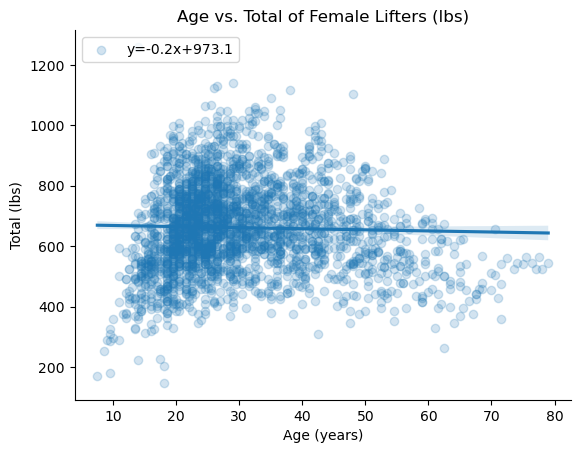

In [54]:
# Plotting bodyweight vs total of female lifters
slope_f, intercept_f, r_value_f, p_value_f, se_f = stats.linregress(nj_with_age.loc[nj.Sex=='F', 'Age'], nj_with_age.loc[nj.Sex=='F', 'TotalLb'])

sb.regplot(y='TotalLb', x='Age', data=nj_with_age[nj_with_age.Sex == 'F'], scatter_kws={'alpha':0.2}, label='y={0:.1f}x+{1:.1f}'.format(slope_f, intercept_f)).legend(loc='upper left')
label_and_despine('Age vs. Total of Female Lifters (lbs)', 'Age (years)', 'Total (lbs)')

<p>There is definitely more of a relationship between age and total for male lifters, and predictably the weights tend to increase until about age 30, and then start to slowly decrease. What is interesting is that age doesn't seem to have as large of an effect on female lifters, where the trendline has a slope that is quite close to 0.</p>

<p>These graphs also demonstrate that the bulk of competitors for both male and female lifters are in their 20s and 30s, with males also competing a lot from their teens up until their mid 30s.</p>

## How performances have changed over the years

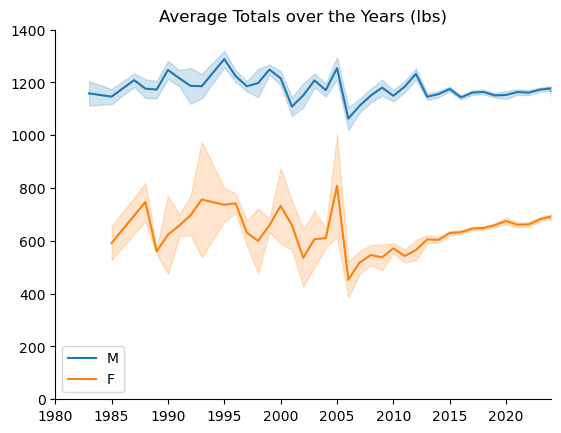

In [55]:
# Plotting total as a function of time
g = sb.lineplot(data=nj[['MeetYear','Sex','TotalLb']], x = 'MeetYear', y = 'TotalLb', hue = 'Sex', errorbar = 'se')
g.legend(loc = 'lower left')
g.set(ylim = (0,1400))
g.set(xlim = (1980,2024))
label_and_despine('Average Totals over the Years (lbs)')

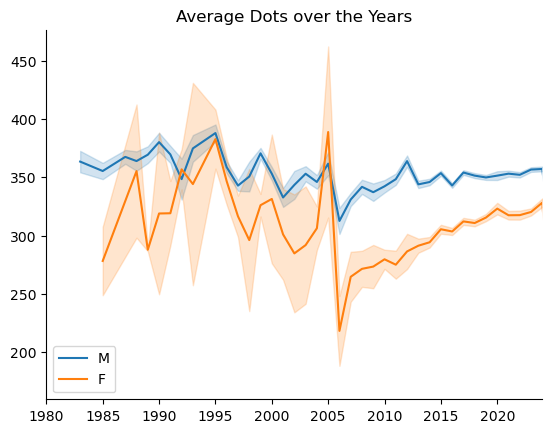

In [56]:
# Plotting dots as a function of time
g = sb.lineplot(data=nj[['MeetYear','Sex','Dots']], x = 'MeetYear', y = 'Dots', hue = 'Sex', errorbar = 'se')
g.legend(loc = 'lower left')
g.set(xlim = (1980,2024))
label_and_despine('Average Dots over the Years')

In [63]:
# Looking at the averages of a few measures for the first and last year in the dataset (that contains data for both males and females).
nj.loc[(nj['MeetYear'] == 1985) | (nj['MeetYear'] == 2024), ['Sex', 'MeetYear', 'BodyweightLb', 'Best3BenchLb', 'Best3SquatLb', 'Best3DeadliftLb', 'TotalLb', 'Dots']].groupby(['Sex', 'MeetYear']).agg('mean')

BodyweightLb  Best3BenchLb  Best3SquatLb  Best3DeadliftLb  \
Sex MeetYear                                                              
F   1985        151.500000    129.428571    209.628571       252.628571   
    2024        148.597826    140.609239    250.608152       301.574728   
M   1985        182.475641    291.632051    404.069231       450.702564   
    2024        191.540000    273.202871    422.498317       481.868119   

                  TotalLb        Dots  
Sex MeetYear                           
F   1985       591.685714  278.294286  
    2024       692.791848  328.290435  
M   1985      1146.406410  355.347821  
    2024      1177.568515  357.089911

Wow it looks like totals and Dots have stayed pretty much consistent since 1985 for male lifters, and increased by about 17% for female lifters. I wonder if one possible explanation could be that more lifters have started competing in powerlifting. Let's find out!

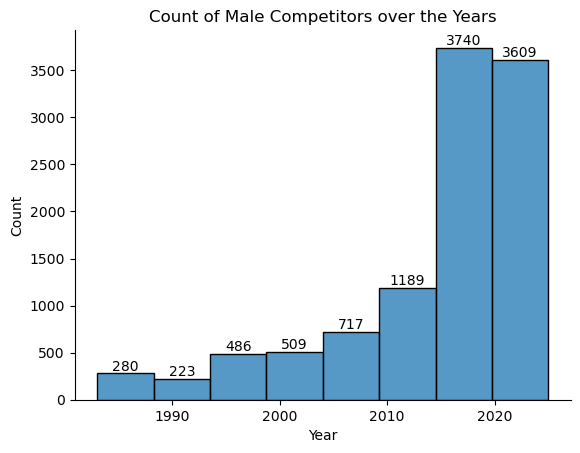

In [107]:
# Plotting number of competitors as a function of time
g = sb.histplot(x='MeetYear', data=nj[nj['Sex']=='M'], binwidth=5)
g.bar_label(g.containers[0])
label_and_despine('Count of Male Competitors over the Years','Year','Count')

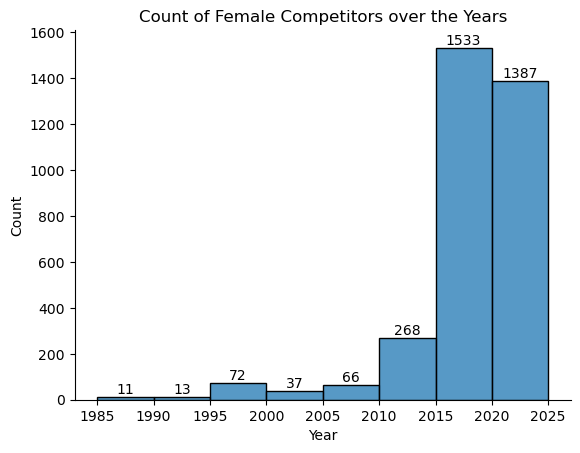

In [98]:
g = sb.histplot(x='MeetYear', data=nj[nj['Sex']=='F'], binwidth=5)
g.bar_label(g.containers[0])
label_and_despine('Count of Female Competitors over the Years', 'Year', 'Count')

<p>Powerlifting really shot up in popularity from 2015 to 2020, absolutely crushing the previous five years' competitor count. It makes sense that the increased number of competitors would have helped female average totals and Dots go up because more women were being introduced to powerlifting, and women who were naturally stronger found competition. However, it also might make sense that his drastic increase in competitors hurt the male averages, as more beginner competitors would bring down the average of the already established elite.</p>

However, this cannot be directly proven, and is more an observation of a possible explanation for the trend.

In [110]:
# Looking at the averages of a few measures for the first and last year in the dataset (that contains data for both males and females).
data = nj.loc[(nj['MeetYear'] == 1985) | (nj['MeetYear'] == 2024), ['Sex', 'MeetYear', 'BodyweightLb', 'Best3BenchLb', 'Best3SquatLb', 'Best3DeadliftLb', 'TotalLb', 'Dots']].groupby(['Sex', 'MeetYear']).agg('mean','count')

# Finding the number of competitors for the years 1985 and 2024
counts = nj.loc[nj['MeetYear'].isin([1985, 2024])].groupby(['Sex', 'MeetYear']).size().to_frame('Counts')

# Merge the counts into the DataFrame
data = data.merge(counts, left_index=True, right_index=True)
display(data)

BodyweightLb  Best3BenchLb  Best3SquatLb  Best3DeadliftLb  \
Sex MeetYear                                                              
F   1985        151.500000    129.428571    209.628571       252.628571   
    2024        148.597826    140.609239    250.608152       301.574728   
M   1985        182.475641    291.632051    404.069231       450.702564   
    2024        191.540000    273.202871    422.498317       481.868119   

                  TotalLb        Dots  Counts  
Sex MeetYear                                   
F   1985       591.685714  278.294286       7  
    2024       692.791848  328.290435     368  
M   1985      1146.406410  355.347821      78  
    2024      1177.568515  357.089911    1010